This is time i write a notebook for classification problem. 

I am looking forward to your considerations

In [102]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset = pd.read_csv(r'../input/social-network-ads/Social_Network_Ads.csv')
dataset = dataset.set_index('User ID')
dataset.head()

/kaggle/input/social-network-ads/Social_Network_Ads.csv


,Gender,Age,EstimatedSalary,Purchased
User ID,,,,
15624510,Male,19,19000,0
15810944,Male,35,20000,0
15668575,Female,26,43000,0
15603246,Female,27,57000,0
15804002,Male,19,76000,0


The dataset contained the information of the customers, 
>     "gender" : categorical variable of 2 classes ['Male' & 'Female']
>     "age" : continuous variable takes the values be the integers
>     "estimated_salary" : continuous vrs 
and these "features" are indexed by `user_ID`. 

The `label ("Purchased")` in this dataset is indexed by `{0 (None), 1 (Done)}`

------------------------------------------

## 1. Using `Logistic regression`

### 1.1. Model with the last 2 feature which be the `continuous variables`

First of all, assign the values of `data` by $X$ and `label` to $y$
Then, look at the proportions of the label

((400, 2), (400,), 257, 143)

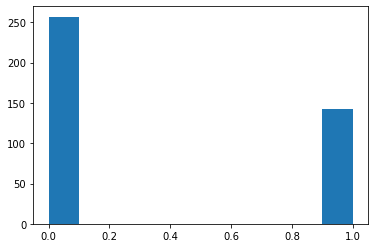

In [103]:
X = dataset.iloc[:,-3:-1].values
y = dataset.iloc[:, -1].values
plt.hist(y);
X.shape, y.shape, len(y[y==0]), len(y[y==1])

We can see that there are 64% dataset has label = 0 (No purchased), so we must add the statement `stratify = y` in the `train_test_split()`

For example, if we take `test_size = 25%` then

$$ \dfrac{\vert y_\text{train} \vert}{\vert y_\text{test} \vert} \approx \dfrac{\vert y_\text{train} \vert}{\vert y_\text{test} \vert } \approx 3 $$

where $\vert A \vert$ denoted the cardinal number of the set $A$.

(3.015625, 2.9722222222222223)

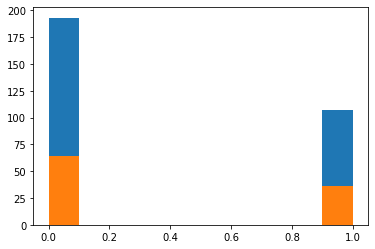

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 33, stratify = y)

plt.hist(y_train)
plt.hist(y_test, stacked = True);
len(y_train[y_train == 0]) / len(y_test[y_test == 0]), len(y_train[y_train == 1]) / len(y_test[y_test == 1])

#### Scaling the features

In [105]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Fit the Logistic_regression model

In [106]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_sc, y_train)

LogisticRegression(random_state=0)

Predict the values in the test_set then evaluate them

In [107]:
y_pred = classifier.predict(X_test_sc)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix :\n', cm)
print("Accuracy: ",accuracy_score(y_test, y_pred))
f1 = f1_score(y_test, y_pred)
print("f1-score:", f1)

confusion matrix :
 [[58  6]
 [ 7 29]]
Accuracy:  0.87
f1-score: 0.8169014084507044


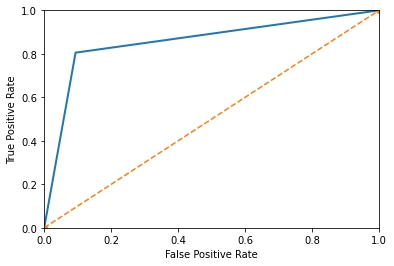

In [108]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'o--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

### 1.2 Using Logistic Regression with full features in model

For the `categorical vrs ("gender")`, we can use `one-hot-encode` to assign it to `{0 (male), 1 (female) }`

In [109]:
from sklearn.preprocessing import OneHotEncoder
X1 = dataset.iloc[:, 0:1].values
enc = OneHotEncoder(handle_unknown='ignore')
x1 = enc.fit_transform(X1).toarray().astype(int)
x1[:3]

array([[0, 1],
       [0, 1],
       [1, 0]])

In [110]:
X_full = np.concatenate((x1, X), axis=1)
X_full[: 3]

array([[    0,     1,    19, 19000],
       [    0,     1,    35, 20000],
       [    1,     0,    26, 43000]])

### Train-test-split dataset

Follow that, `X_train_full = [ X_train_scale(continuous vrs), X_train_one-hot-encode ]`

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size = 0.25, random_state = 33, stratify = y)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train[:, 2:])
X_test_sc = sc.transform(X_test[: ,2:])
X_train_full = np.concatenate((X_train[:, :2], X_train_sc), axis=1)
X_test_full = np.concatenate((X_test[:, :2], X_test_sc), axis=1)

### Fit the model & evaluate

In [112]:
classifier = LogisticRegression(random_state = 33)
classifier.fit(X_train_full, y_train)
y_pred = classifier.predict(X_test_full)
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix :\n', cm)
print("Accuracy: ",accuracy_score(y_test, y_pred))
f1 = f1_score(y_test, y_pred)
print("f1-score:", f1)

confusion matrix :
 [[59  5]
 [ 6 30]]
Accuracy:  0.89
f1-score: 0.8450704225352113


### First summary in logistic regression.

>  Using the last 2 features give "accuracy" is about 0.87 and "f1-score" is about 0.816
> 
>  Using the full-features give "accuracy" is about 0.89 and "f1-score" is about 0.845 which is better than the previous.

## 2. Using Naive-Bayes for the full-model

In [113]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score as acc

clf = GaussianNB()
clf.fit(X_train_full, y_train)
y_pred = clf.predict(X_test_full)
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix :\n', cm)
print("Accuracy: ",accuracy_score(y_test, y_pred))
f1 = f1_score(y_test, y_pred)
print("f1-score:", f1)

confusion matrix :
 [[57  7]
 [ 4 32]]
Accuracy:  0.89
f1-score: 0.8533333333333333


Hence, using `Gaussian Naive Bayes` model, we had improved the "f1-score" to 0.8533

## 3. Using SVM

In [114]:
from sklearn.svm import SVC

kernel_names = ['linear', 'poly', 'rbf', 'sigmoid']
for k in range(4):
    print(' %4sSVM(kernel = "%s") \n================================'%('', kernel_names[k]))
    clf = SVC(kernel = kernel_names[k])
    clf.fit(X_train_full, y_train)
    y_pred_tr = clf.predict(X_train_full)
    y_pred_ts = clf.predict(X_test_full)
    cm = confusion_matrix(y_test, y_pred_ts)
    print('confusion matrix :\n', cm)
    print("Training accuracy: %.4f"%accuracy_score(y_train, y_pred_tr))
    print("Testing accuracy: %.4f"%accuracy_score(y_test, y_pred_ts))
    f1 = f1_score(y_test, y_pred_ts)
    print("f1-score: %.4f"%f1)
    print('================================')

     SVM(kernel = "linear") 
confusion matrix :
 [[58  6]
 [11 25]]
Training accuracy: 0.8300
Testing accuracy: 0.8300
f1-score: 0.7463
     SVM(kernel = "poly") 
confusion matrix :
 [[58  6]
 [ 5 31]]
Training accuracy: 0.9033
Testing accuracy: 0.8900
f1-score: 0.8493
     SVM(kernel = "rbf") 
confusion matrix :
 [[57  7]
 [ 3 33]]
Training accuracy: 0.9133
Testing accuracy: 0.9000
f1-score: 0.8684
     SVM(kernel = "sigmoid") 
confusion matrix :
 [[52 12]
 [20 16]]
Training accuracy: 0.6533
Testing accuracy: 0.6800
f1-score: 0.5000


So, with `SVM(kernel = 'rbf')`, we improved the "f1-score" to `0.868`

## 4. Using K-nn or `K-nearest neighbor`

In [115]:
from sklearn.neighbors import KNeighborsClassifier

for k in [2, 10, 20, 100]:
    print('\tUsing KNN with n_neighbors = %s \n %5s =====================%5s'%(k,'', ''))
    knn = KNeighborsClassifier(n_neighbors = k)
    clf = knn.fit(X_train_full, y_train)
    y_pred_tr = clf.predict(X_train_full)
    y_pred_ts = clf.predict(X_test_full)
    cm = confusion_matrix(y_test, y_pred_ts)
    print('confusion matrix :\n', cm)
    print("Training accuracy: %.4f"%accuracy_score(y_train, y_pred_tr))
    print("Testing accuracy: %.4f"%accuracy_score(y_test, y_pred_ts))
    f1 = f1_score(y_test, y_pred_ts)
    print("f1-score: %.4f"%f1)
    print('===============================================')

	Using KNN with n_neighbors = 2 
confusion matrix :
 [[61  3]
 [ 7 29]]
Training accuracy: 0.9367
Testing accuracy: 0.9000
f1-score: 0.8529
	Using KNN with n_neighbors = 10 
confusion matrix :
 [[58  6]
 [ 3 33]]
Training accuracy: 0.9167
Testing accuracy: 0.9100
f1-score: 0.8800
	Using KNN with n_neighbors = 20 
confusion matrix :
 [[58  6]
 [ 5 31]]
Training accuracy: 0.9000
Testing accuracy: 0.8900
f1-score: 0.8493
	Using KNN with n_neighbors = 100 
confusion matrix :
 [[62  2]
 [21 15]]
Training accuracy: 0.7833
Testing accuracy: 0.7700
f1-score: 0.5660


In the `KNN with k = 10`, we obtain the higest "f1-score" = 0.88

## 5. Using Adaboost

In [116]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

for lr in [0.1, 1, 10]:
    for n_est in [10, 20, 30]:
        print('AdaBoostClassifier(n_estimators = %s, learning_rate = %s)\n %10s===================================%10s'%(n_est, lr, '', ''))
        clf = AdaBoostClassifier(n_estimators = 30,
                                 learning_rate = 1)
        clf.fit(X_train_full, y_train)
        y_pred = clf.predict(X_test)
        y_pred_tr = clf.predict(X_train_full)
        y_pred_ts = clf.predict(X_test_full)
        cm = confusion_matrix(y_test, y_pred_ts)
        print('confusion matrix :\n', cm)
        print("Training accuracy: %.4f"%accuracy_score(y_train, y_pred_tr))
        print("Testing accuracy: %.4f"%accuracy_score(y_test, y_pred_ts))
        f1 = f1_score(y_test, y_pred_ts)
        print("f1-score: %.4f"%f1)
        print('==========================================================')

AdaBoostClassifier(n_estimators = 10, learning_rate = 0.1)
confusion matrix :
 [[58  6]
 [ 6 30]]
Training accuracy: 0.9200
Testing accuracy: 0.8800
f1-score: 0.8333
AdaBoostClassifier(n_estimators = 20, learning_rate = 0.1)
confusion matrix :
 [[58  6]
 [ 6 30]]
Training accuracy: 0.9200
Testing accuracy: 0.8800
f1-score: 0.8333
AdaBoostClassifier(n_estimators = 30, learning_rate = 0.1)
confusion matrix :
 [[58  6]
 [ 6 30]]
Training accuracy: 0.9200
Testing accuracy: 0.8800
f1-score: 0.8333
AdaBoostClassifier(n_estimators = 10, learning_rate = 1)
confusion matrix :
 [[58  6]
 [ 6 30]]
Training accuracy: 0.9200
Testing accuracy: 0.8800
f1-score: 0.8333
AdaBoostClassifier(n_estimators = 20, learning_rate = 1)
confusion matrix :
 [[58  6]
 [ 6 30]]
Training accuracy: 0.9200
Testing accuracy: 0.8800
f1-score: 0.8333
AdaBoostClassifier(n_estimators = 30, learning_rate = 1)
confusion matrix :
 [[58  6]
 [ 6 30]]
Training accuracy: 0.9200
Testing accuracy: 0.8800
f1-score: 0.8333
AdaBoostCl

Using `AdaBoost`, we obtain the "f1-score" about 0.833 which is not better than using `SVM(kernel = 'rbf')` or `KNN(n_neighbors = 10)`

## 6. Using XGBoost

In [117]:
from xgboost import XGBClassifier

f1_scores = []
for dpt in [3, 5, 15, 30, 50]:
    print('%8s XGBClassifier(max_depth = %s)\n %5s===================================%5s'%('', dpt, '', ''))
    clf = XGBClassifier(max_depth = dpt) 
    clf.fit(X_train_full, y_train, eval_metric="auc")
    y_pred = clf.predict(X_test)
    y_pred_tr = clf.predict(X_train_full)
    y_pred_ts = clf.predict(X_test_full)
    cm = confusion_matrix(y_test, y_pred_ts)
    print('confusion matrix :\n', cm)
    print("Training accuracy: %.4f"%accuracy_score(y_train, y_pred_tr))
    print("Testing accuracy: %.4f"%accuracy_score(y_test, y_pred_ts))
    f1 = f1_score(y_test, y_pred_ts)
    print("f1-score: %.4f"%f1)
    print('==========================================================')
    f1_scores.append(f1)
    
max(f1_scores)

         XGBClassifier(max_depth = 3)
confusion matrix :
 [[57  7]
 [ 4 32]]
Training accuracy: 0.9667
Testing accuracy: 0.8900
f1-score: 0.8533
         XGBClassifier(max_depth = 5)
confusion matrix :
 [[57  7]
 [ 4 32]]
Training accuracy: 0.9867
Testing accuracy: 0.8900
f1-score: 0.8533
         XGBClassifier(max_depth = 15)
confusion matrix :
 [[57  7]
 [ 4 32]]
Training accuracy: 0.9867
Testing accuracy: 0.8900
f1-score: 0.8533
         XGBClassifier(max_depth = 30)
confusion matrix :
 [[57  7]
 [ 4 32]]
Training accuracy: 0.9867
Testing accuracy: 0.8900
f1-score: 0.8533
         XGBClassifier(max_depth = 50)
confusion matrix :
 [[57  7]
 [ 4 32]]
Training accuracy: 0.9867
Testing accuracy: 0.8900
f1-score: 0.8533


0.8533333333333333

By using `XGBoost`, we obtain the "f1-score" is about 0.8533 which is not better than using `SVM(kernel = "rbf")` and `KNN(n_neighbors = 10)`.

## 7. Using Random Forest Classifier

In [120]:
from sklearn.ensemble import RandomForestClassifier

f1_scores = []
for m_dpt in [2, 5, 10]:
    for n_est in [20, 50, 100, 300]:
        print('RandomForestClassifier(n_estimators = %s, max_depth = %s)\n %10s===================================%10s'%(n_est, m_dpt, '', ''))
        clf = RandomForestClassifier(max_depth = 3, n_estimators = 300)
        clf.fit(X_train_full, y_train)
        y_pred = clf.predict(X_test)
        y_pred_tr = clf.predict(X_train_full)
        y_pred_ts = clf.predict(X_test_full)
        cm = confusion_matrix(y_test, y_pred_ts)
        print('confusion matrix :\n', cm)
        print("Training accuracy: %.4f"%accuracy_score(y_train, y_pred_tr))
        print("Testing accuracy: %.4f"%accuracy_score(y_test, y_pred_ts))
        f1 = f1_score(y_test, y_pred_ts)
        print("f1-score: %.4f"%f1)
        print('==========================================================')
        f1_scores.append(f1)
    
max(f1_scores)

RandomForestClassifier(n_estimators = 20, max_depth = 2)
confusion matrix :
 [[56  8]
 [ 3 33]]
Training accuracy: 0.9267
Testing accuracy: 0.8900
f1-score: 0.8571
RandomForestClassifier(n_estimators = 50, max_depth = 2)
confusion matrix :
 [[56  8]
 [ 3 33]]
Training accuracy: 0.9267
Testing accuracy: 0.8900
f1-score: 0.8571
RandomForestClassifier(n_estimators = 100, max_depth = 2)
confusion matrix :
 [[56  8]
 [ 3 33]]
Training accuracy: 0.9267
Testing accuracy: 0.8900
f1-score: 0.8571
RandomForestClassifier(n_estimators = 300, max_depth = 2)
confusion matrix :
 [[56  8]
 [ 3 33]]
Training accuracy: 0.9267
Testing accuracy: 0.8900
f1-score: 0.8571
RandomForestClassifier(n_estimators = 20, max_depth = 5)
confusion matrix :
 [[56  8]
 [ 3 33]]
Training accuracy: 0.9267
Testing accuracy: 0.8900
f1-score: 0.8571
RandomForestClassifier(n_estimators = 50, max_depth = 5)
confusion matrix :
 [[56  8]
 [ 3 33]]
Training accuracy: 0.9267
Testing accuracy: 0.8900
f1-score: 0.8571
RandomForestCl

0.8571428571428571

Hence, the `RandomForestClassifier` gives the highest "f1-score" = 0.857

## 8. Finally, find the best model by using TpotClassifier

In [121]:
from tpot import TPOTClassifier
tpot_clf = TPOTClassifier(generations=10, population_size=10, offspring_size=3 , cv=5,
                          verbosity=2, random_state=42)
tpot_clf.fit(X_train_full, y_train)


Generation 1 - Current best internal CV score: 0.9199999999999999
Generation 2 - Current best internal CV score: 0.9199999999999999
Generation 3 - Current best internal CV score: 0.9199999999999999
Generation 4 - Current best internal CV score: 0.9199999999999999
Generation 5 - Current best internal CV score: 0.9199999999999999
Generation 6 - Current best internal CV score: 0.9199999999999999
Generation 7 - Current best internal CV score: 0.9199999999999999
Generation 8 - Current best internal CV score: 0.9199999999999999
Generation 9 - Current best internal CV score: 0.9199999999999999
Generation 10 - Current best internal CV score: 0.9199999999999999
Best pipeline: ExtraTreesClassifier(RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.6000000000000001, min_samples_leaf=20, min_samples_split=10, n_estimators=100), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=18, min_samples_split=9, n_estimators=100)


TPOTClassifier(generations=10,
               log_file=<ipykernel.iostream.OutStream object at 0x7fd9f5666110>,
               offspring_size=3, population_size=10, random_state=42,
               verbosity=2)

In [123]:
tpot_clf.fit(X_train_full, y_train)


Generation 1 - Current best internal CV score: 0.9199999999999999
Generation 2 - Current best internal CV score: 0.9199999999999999
Generation 3 - Current best internal CV score: 0.9199999999999999
Generation 4 - Current best internal CV score: 0.9199999999999999
Generation 5 - Current best internal CV score: 0.9199999999999999
Generation 6 - Current best internal CV score: 0.9199999999999999
Generation 7 - Current best internal CV score: 0.9199999999999999
Generation 8 - Current best internal CV score: 0.9199999999999999
Generation 9 - Current best internal CV score: 0.9199999999999999
Generation 10 - Current best internal CV score: 0.9199999999999999
Best pipeline: ExtraTreesClassifier(RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.6000000000000001, min_samples_leaf=20, min_samples_split=10, n_estimators=100), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=18, min_samples_split=9, n_estimators=100)
0.89


In [ ]:
print(tpot_clf.score(X_test_full, y_test))